In [ ]:
from google.colab import files
uploaded = files.upload()    # Upload zip file


Saving train(1).csv to train(1).csv


In [ ]:
!pip install shap


In [ ]:
uploaded.keys()



dict_keys(['train(1).csv'])

In [ ]:
import gc


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,classification_report, precision_score, recall_score, f1_score,confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("train(1).csv")
df.head()


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
print(f"✅ Dataset loaded: {df.shape}")


✅ Dataset loaded: (200000, 202)


In [ ]:
for col in df.select_dtypes(include=["float64"]).columns:
    df[col] = df[col].astype("float32")
for col in df.select_dtypes(include=["int64"]).columns:
    df[col] = df[col].astype("int32")

In [ ]:
X = df.drop(["ID_code", "target"], axis=1)
y = df["target"]

print("\nTarget distribution:")
print(y.value_counts(normalize=True))


Target distribution:
target
0    0.89951
1    0.10049
Name: proportion, dtype: float64


In [ ]:
len(df)

200000

In [ ]:
correlations = X.apply(lambda col: col.corr(y))
print("\nTop 10 correlated features with target:")
print(correlations.abs().sort_values(ascending=False).head(10))


Top 10 correlated features with target:
var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
var_110    0.064275
var_146    0.063644
var_53     0.063399
var_26     0.062422
var_76     0.061917
var_174    0.061669
dtype: float64


In [ ]:
##############################
# ✅ 1. IMPORTS
##############################
import pandas as pd
import numpy as np
import shap
import gc
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib

# Load your dataset
# df = pd.read_csv("your_file.csv")

###########################################
# ✅ 2. TRAIN OVER MULTIPLE SAMPLE SIZES
###########################################
sample_sizes = [5000, 10000, 20000, 50000, 100000, len(df)]
results = []
best_model = None
best_auc = 0

for size in sample_sizes:
    print(f"\n==============================")
    print(f"Training with {size} samples")
    print(f"==============================")

    df_sample = df.sample(size, random_state=42).reset_index(drop=True)
    X = df_sample.drop(['ID_code', 'target'], axis=1)
    y = df_sample['target']

    # ✅ Variance Threshold
    var = VarianceThreshold(threshold=0.01)
    X_var = var.fit_transform(X)

    # ✅ Feature selection using Random Forest importance
    rf_temp = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced')
    rf_temp.fit(X_var, y)
    importances = rf_temp.feature_importances_
    top_idx = np.argsort(importances)[::-1][:100]
    X_selected = X_var[:, top_idx]

    # ✅ Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, stratify=y, random_state=42
    )

    # ✅ SMOTE for imbalance
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    # ✅ Scaling for Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ################################
    # ✅ Train Models (AutoML Style)
    ################################
    models = {
        "Logistic Regression": GridSearchCV(
            LogisticRegression(max_iter=5000, solver='saga', class_weight='balanced', n_jobs=-1),
            {'C': [0.01, 0.1, 1]},
            scoring='roc_auc', cv=3, n_jobs=-1
        ),
        "Random Forest": GridSearchCV(
            RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
            {'n_estimators': [100], 'max_depth': [10, 20]},
            scoring='roc_auc', cv=3, n_jobs=-1
        ),
        "XGBoost": GridSearchCV(
            XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1),
            {'max_depth': [3, 5], 'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200]},
            scoring='roc_auc', cv=3, n_jobs=-1
        )
    }

    # ✅ Train and evaluate
    for name, model in models.items():
        X_eval_train = X_train_scaled if name == "Logistic Regression" else X_train
        X_eval_test = X_test_scaled if name == "Logistic Regression" else X_test

        model.fit(X_eval_train, y_train)
        y_pred = model.predict(X_eval_test)
        y_prob = model.predict_proba(X_eval_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)

        results.append({
            'sample_size': size,
            'model': name,
            'roc_auc': auc,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'best_params': model.best_params_
        })

        # ✅ Keep track of best model
        if auc > best_auc:
            best_auc = auc
            best_model = model.best_estimator_
            best_scaler = scaler
            best_var = var
            best_top_idx = top_idx

    del X, y, X_train, X_test, y_train, y_test, X_selected
    gc.collect()

results_df = pd.DataFrame(results)
print("\n==== MODEL PERFORMANCE ====")
print(results_df)

###########################################
# ✅ 3. EXPLAIN MODEL WITH SHAP
###########################################
print("\nGenerating SHAP explanations...")

# Take 2000 samples for faster SHAP
df_shap = df.sample(2000, random_state=42)
X_full = df_shap.drop(['ID_code', 'target'], axis=1)

# Apply same feature selection
X_var_full = best_var.transform(X_full)
X_final = X_var_full[:, best_top_idx]

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_final)

# ✅ SHAP Summary Plot
shap.summary_plot(shap_values, X_final, show=True)

###########################################
# ✅ 4. SAVE MODEL & SELECTORS
###########################################
joblib.dump(best_model, "best_customer_model.pkl")
joblib.dump(best_var, "variance_filter.pkl")
np.save("top_features.npy", best_top_idx)
joblib.dump(best_scaler, "scaler.pkl")

print("\n✅ Saved: best model, scaler, variance selector, selected features.")

###########################################
# ✅ 5. GENERATE PREDICTIONS FOR ALL CUSTOMERS
###########################################
df_pred = df.copy()

Xp = df_pred.drop(['ID_code', 'target'], axis=1)
Xp = best_var.transform(Xp)
Xp = Xp[:, best_top_idx]

Xp_scaled = best_scaler.transform(Xp) if isinstance(best_model, LogisticRegression) else Xp
df_pred['transaction_probability'] = best_model.predict_proba(Xp_scaled)[:, 1]
df_pred['prediction'] = (df_pred['transaction_probability'] > 0.5).astype(int)

df_pred.to_csv("customer_predictions.csv", index=False)
print("\n✅ Predictions saved to customer_predictions.csv")

###########################################
# ✅ 6. SIMPLE MATPLOTLIB VISUALIZATION
###########################################
plt.hist(df_pred['transaction_probability'], bins=30)
plt.title("Probability Distribution of Transaction Likelihood")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

print("\n✅ DONE: Training, SHAP, Saving Model, Predictions, Visualization.")



Training with 5000 samples

Training with 10000 samples

Training with 20000 samples

Training with 50000 samples

Training with 100000 samples

Training with 200000 samples

==== MODEL PERFORMANCE ====
    sample_size                model   roc_auc  accuracy  precision    recall  \
0          5000  Logistic Regression  0.786341  0.763000   0.242424  0.633663   
1          5000        Random Forest  0.693328  0.889000   0.250000  0.049505   
2          5000              XGBoost  0.701814  0.881000   0.295455  0.128713   
3         10000  Logistic Regression  0.819662  0.765500   0.253676  0.686567   
4         10000        Random Forest  0.685309  0.886500   0.333333  0.129353   
5         10000              XGBoost  0.697607  0.872500   0.324675  0.248756   
6         20000  Logistic Regression  0.825910  0.771750   0.268315  0.719902   
7         20000        Random Forest  0.689354  0.875750   0.265625  0.125307   
8         20000              XGBoost  0.700276  0.859500   0.289973

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>

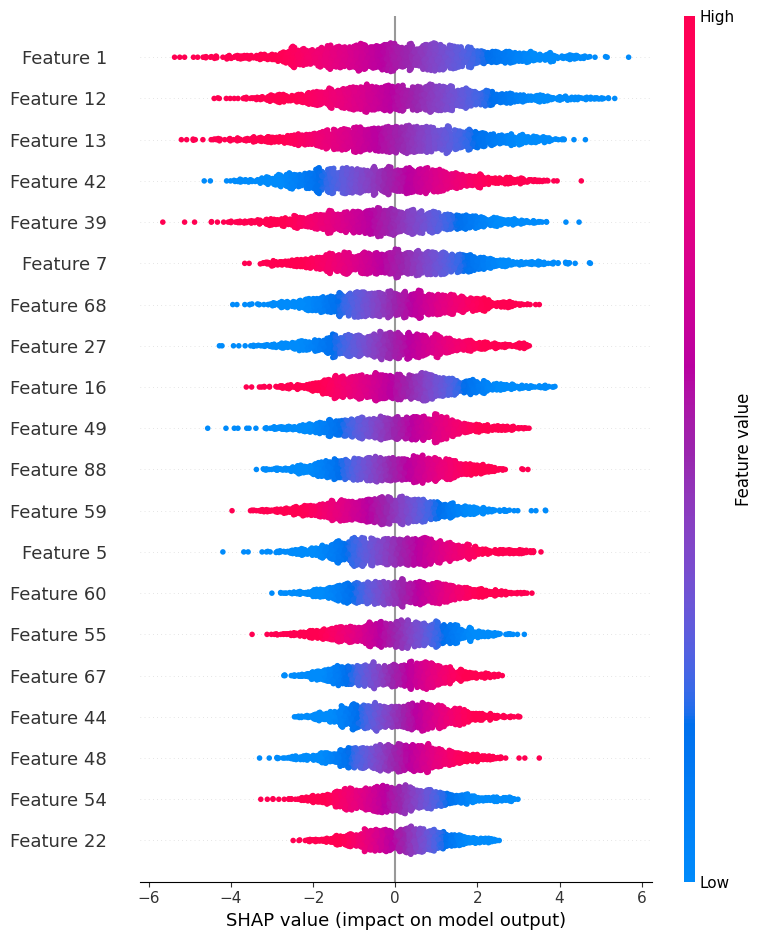

In [ ]:
explainer = shap.Explainer(best_model, X_final)
shap_values = explainer(X_final)
shap.summary_plot(shap_values, X_final)


In [ ]:
df_pred = df.copy()

Xp = df_pred.drop(['ID_code', 'target'], axis=1)
Xp = best_var.transform(Xp)
Xp = Xp[:, best_top_idx]

Xp_scaled = best_scaler.transform(Xp) if isinstance(best_model, LogisticRegression) else Xp
df_pred['transaction_probability'] = best_model.predict_proba(Xp_scaled)[:, 1]
df_pred['prediction'] = (df_pred['transaction_probability'] > 0.5).astype(int)

df_pred.to_csv("customer_predictions.csv", index=False)
print("\n✅ Predictions saved to customer_predictions.csv")


✅ Predictions saved to customer_predictions.csv


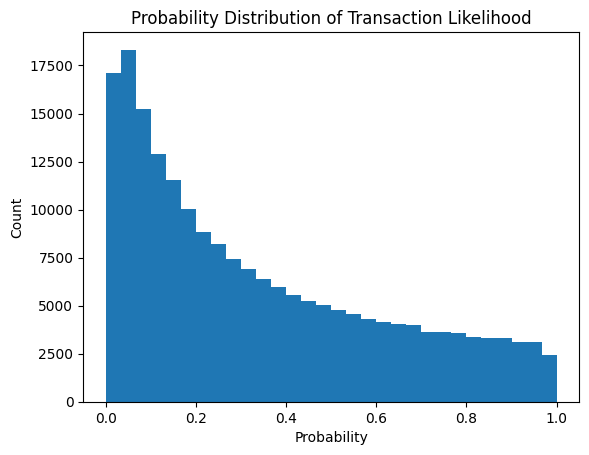


✅ DONE: Training, SHAP, Saving Model, Predictions, Visualization.


In [ ]:

plt.hist(df_pred['transaction_probability'], bins=30)
plt.title("Probability Distribution of Transaction Likelihood")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

print("\n✅ DONE: Training, SHAP, Saving Model, Predictions, Visualization.")




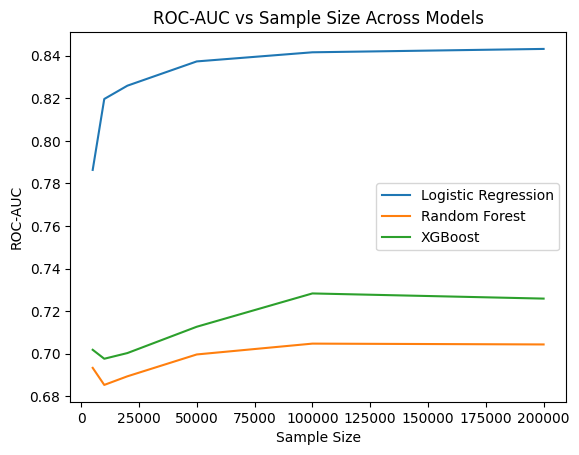

In [ ]:
models = ["Logistic Regression", "Random Forest", "XGBoost"]

for model in models:
    subset = results_df[results_df["model"] == model]
    plt.plot(subset["sample_size"], subset["roc_auc"], label=model)

plt.xlabel("Sample Size")
plt.ylabel("ROC-AUC")
plt.title("ROC-AUC vs Sample Size Across Models")
plt.legend()
plt.show()

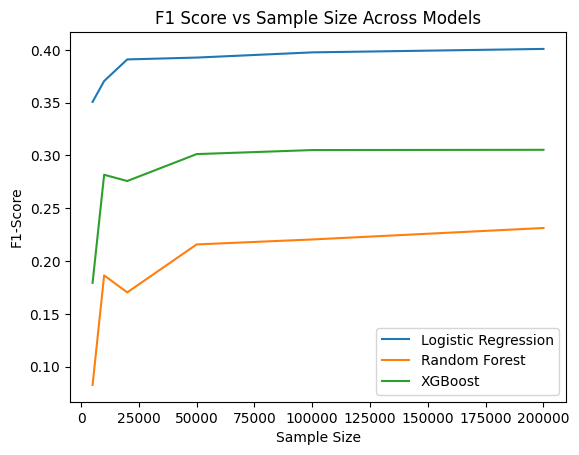

In [ ]:
for model in models:
    subset = results_df[results_df["model"] == model]
    plt.plot(subset["sample_size"], subset["f1"], label=model)

plt.xlabel("Sample Size")
plt.ylabel("F1-Score")
plt.title("F1 Score vs Sample Size Across Models")
plt.legend()
plt.show()


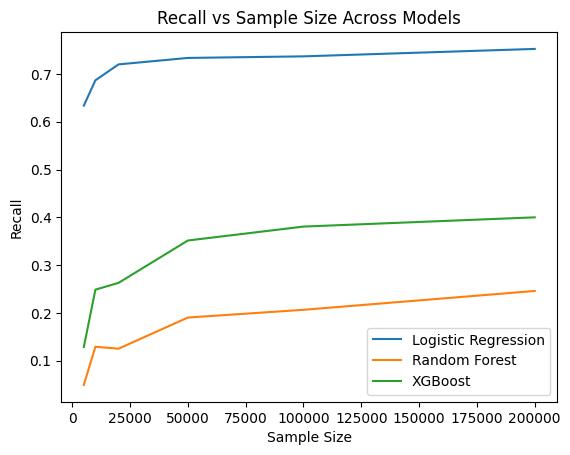

In [ ]:
for model in models:
    subset = results_df[results_df["model"] == model]
    plt.plot(subset["sample_size"], subset["recall"], label=model)

plt.xlabel("Sample Size")
plt.ylabel("Recall")
plt.title("Recall vs Sample Size Across Models")
plt.legend()
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Train final LR model on full data
final_model = LogisticRegression(
    C=0.01,
    max_iter=2000,
    class_weight="balanced"
)
final_model.fit(X_train_scaled, y_train)

# ✅ Evaluate
pred = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)[:,1]

print("\n===== FINAL MODEL PERFORMANCE =====")
print(classification_report(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, probs))
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred))

# ✅ Save model for future deployment
joblib.dump(final_model, "final_logistic.pkl")
joblib.dump(scaler, "scaler.pkl")

print("\n✅ SAVED: final_logistic.pkl + scaler.pkl")


===== FINAL MODEL PERFORMANCE =====
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     35980
           1       0.29      0.78      0.42      4020

    accuracy                           0.78     40000
   macro avg       0.63      0.78      0.64     40000
weighted avg       0.90      0.78      0.82     40000

ROC-AUC: 0.8599015000041481
Confusion Matrix:
[[28217  7763]
 [  903  3117]]

✅ SAVED: final_logistic.pkl + scaler.pkl


In [ ]:
from google.colab import files

files.download("final_logistic.pkl")
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = joblib.load("final_logistic.pkl")
scaler = joblib.load("scaler.pkl")

def predict_transaction(new_data_df):
    """
    new_data_df: DataFrame containing var_0 ... var_199
    Returns DataFrame with predictions and probabilities
    """
    scaled = scaler.transform(new_data_df)
    preds = model.predict(scaled)
    probs = model.predict_proba(scaled)[:,1]

    result = new_data_df.copy()
    result["will_transact"] = preds
    result["probability"] = probs
    return result

In [ ]:
pred_df = predict_transaction(X_test)
high_prob = pred_df[pred_df["probability"] > 0.7]
print(high_prob.head())


          var_0   var_1    var_2   var_3    var_4      var_5   var_6  \
64177    8.1423  2.4038   9.1426  4.3581  13.4272 -16.703899  6.2282   
190496  14.1423 -3.1940  13.7825  6.4443   7.4344   9.319700  5.6504   
113645   8.5407 -0.3217   7.5672  5.2474  13.4077  -8.255400  4.9308   
67074   10.6587 -7.3937  13.6153  9.0063   9.7875 -15.300300  4.7754   
176102  10.0445  0.9304  13.6783  4.7542  11.0490   4.987400  6.3561   

            var_7   var_8   var_9  ...  var_192  var_193    var_194  var_195  \
64177   12.472700 -6.7823  6.2709  ...   1.0247   5.7786  16.417500   1.8093   
190496  16.665800 -3.4792  8.8621  ...   2.1455   5.3711  17.397800   0.0966   
113645  20.755301  4.1173  7.4338  ...  -0.3038   6.4751  18.061300  -0.6190   
67074   10.733200 -5.2806  7.0275  ...   1.9662  -5.5939  17.601299   1.0656   
176102  21.059500 -7.9386  6.6448  ...  -0.0225  -1.9052  18.166800  -1.4208   

        var_196  var_197  var_198  var_199  will_transact  probability  
64177   -8.04

In [ ]:
all_pred = pred_df[pred_df["will_transact"] == 1]

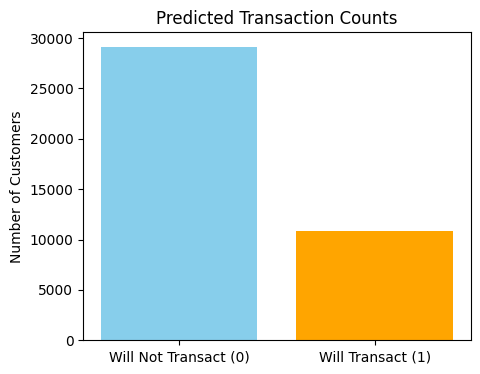

In [ ]:

# Count predicted classes
counts = pred_df["will_transact"].value_counts()

# Bar plot
plt.figure(figsize=(5,4))
plt.bar(["Will Not Transact (0)", "Will Transact (1)"], counts, color=["skyblue", "orange"])
plt.ylabel("Number of Customers")
plt.title("Predicted Transaction Counts")
plt.show()


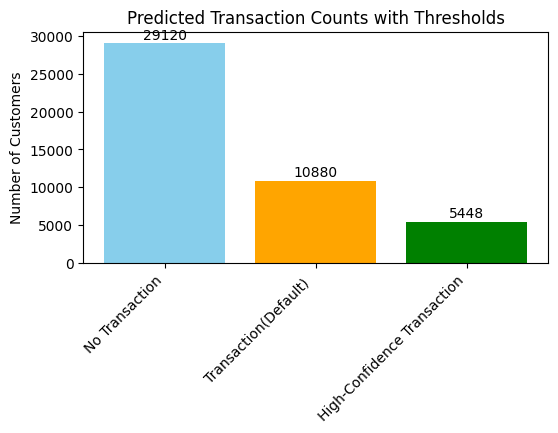

In [ ]:
import matplotlib.pyplot as plt

# Count customers in each category
not_transact = (pred_df["probability"] <= 0.5).sum()
transact_default = (pred_df["probability"] >= 0.5).sum()
high_confidence = (pred_df["probability"] >= 0.7).sum()

# Bar plot
plt.figure(figsize=(6,3))
bars = plt.bar(
    ["No Transaction", "Transaction(Default) ", "High-Confidence Transaction"],
    [not_transact, transact_default, high_confidence],
    color=["skyblue", "orange", "green"]
)

plt.ylabel("Number of Customers")
plt.title("Predicted Transaction Counts with Thresholds")
plt.xticks(rotation=45, ha='right')


# Add counts on top of bars
for i, val in enumerate([not_transact, transact_default, high_confidence]):
    plt.text(i, val + 100, val, ha='center', va='bottom')

plt.show()


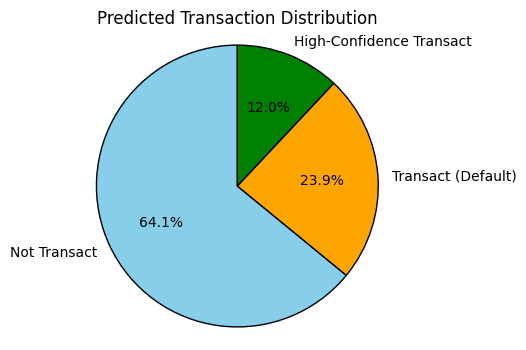

In [ ]:
labels = ["Not Transact", "Transact (Default)", "High-Confidence Transact"]
sizes = [not_transact, transact_default, high_confidence]
colors = ["skyblue", "orange", "green"]

# Pie chart
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor':'black'})
plt.title("Predicted Transaction Distribution")
plt.axis('equal')  # Equal aspect ratio ensures pie is round
plt.show()








In [ ]:
import streamlit as st

In [ ]:
st.title("Customer Transaction Prediction")

uploaded_file = st.file_uploader("Upload CSV with features", type="csv")
if uploaded_file:
    new_customers = pd.read_csv(uploaded_file)
    predictions = predict_transaction(new_customers)
    st.dataframe(predictions)
    predictions.to_csv("predictions.csv", index=False)
    st.success("✅ Predictions saved to predictions.csv")